## This script creates plots for finer scale model evaluations

This includes:
1. Process data for further analysis
2. Double-mass plot
3. Event Mean Concentration or seasonal concentration across all years.

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Function for convert data to 
def norm_data(df, flow_col, din_load_col):
    """
    df: dataframe containing datetime, daily flow and load.
    """
    # Sample DataFrame creation (replace this with your actual DataFrame)
    # Define water year: if the month is July (7) or later, it belongs to the next calendar year
    breakpoint()
    df['water_year'] = df['date'].apply(lambda x: x.year - 1 if x.month < 7 else x.year)
    # Normalize the data within each water year
    df['normalized_flow'] = df.groupby('water_year')[flow_col].transform(lambda x: x / x.sum())
    df['normalized_DIN_load'] = df.groupby('water_year')[din_load_col].transform(lambda x: x / x.sum())
    # Add cumulative columns
    df['cum_flow'] = df.groupby('water_year')['normalized_flow'].cumsum()
    df['cum_din_load'] = df.groupby('water_year')['normalized_DIN_load'].cumsum()
    return df

In [4]:
## Read model simulations
dir = '../output/DailyData_work_100_0.005_4_unbase/'
mod_fn_list = os.listdir(dir)
mod_fn_list = [fn for fn in mod_fn_list if '_' in fn ]
cum_fn = 'ModCumuFlowLoad.xlsx' # Excel file for saving cumulative normalized flow and loads.
flow_col = 'Q (m3/s)'; din_load_col = 'Load (t)'
# Calculate the cumulative normalized value for flow and load.
with pd.ExcelWriter(dir + cum_fn) as writer:
    for fn in mod_fn_list:
        flow_load = pd.read_csv(dir + fn)
        flow_load.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
        flow_load['date'] = pd.to_datetime(flow_load['date'], format='%Y-%m-%d')
        df = norm_data(flow_load, flow_col, din_load_col)
        df.to_excel(writer, sheet_name=fn.split('.')[0], index=False)

In [53]:
## Read model simulations
data_dir = '../data/'
obs_fn = 'obs_low_interp_flow.csv'
cum_fn = 'ObsCumuFlowLoad.csv' # Excel file for saving cumulative normalized flow and loads.
obs_flow_load = pd.read_csv(data_dir + obs_fn)
obs_flow_load['date'] = pd.to_datetime(obs_flow_load['date'], format='%d/%m/%Y')
# Calculate the cumulative normalized value for flow and load.
df = norm_data(obs_flow_load, flow_col, din_load_col)
df.to_csv(data_dir + cum_fn, index = 'date')

### 3-1 Double-mass plot

In [56]:
# Read cumulative of normalized data
fn_obs = 'ObsCumuFlowLoad.csv'
df_obs = pd.read_csv(f'{data_dir}{fn_obs}');
fn_mod = 'ModCumuFlowLoad.xlsx'
df_mod = pd.read_excel(f'{dir}{fn_mod}', sheet_name='RUN_0');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


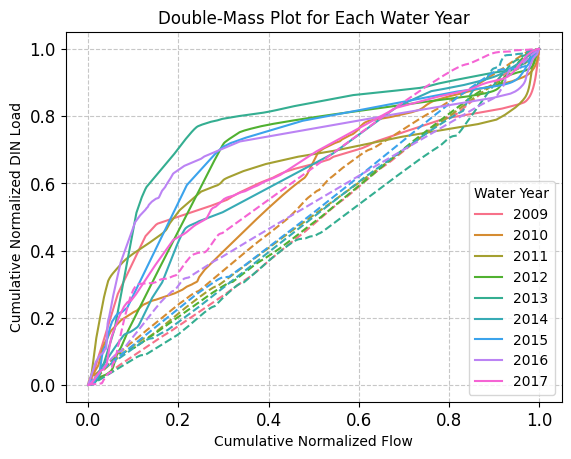

In [57]:
# Set up colors using Seaborn
unique_years = df_mod[df_mod['water_year'] <= 2017]['water_year'].unique()
palette = sns.color_palette("husl", len(unique_years))  # Using a hue-saturation-lightness palette

for i, water_year in enumerate(unique_years):
    year_data = df_mod[df_mod['water_year'] == water_year]
    # Cumulative sum for double-mass plot
    cum_flow = year_data['cum_flow']
    cum_din_load = year_data['cum_din_load']

    obs_year_data = df_obs[df_obs['water_year'] == water_year]
    obs_cum_flow = obs_year_data['cum_flow']
    obs_cum_din_load = obs_year_data['cum_din_load']
    plt.plot(cum_flow, cum_din_load, color=palette[i], linestyle = '--')
    # Hide the legend
    plt.legend().set_visible(False)
    plt.plot(obs_cum_flow, obs_cum_din_load, label=str(water_year), color=palette[i])


plt.title('Double-Mass Plot for Each Water Year')
plt.xlabel('Cumulative Normalized Flow')
plt.ylabel('Cumulative Normalized DIN Load')
plt.legend(title='Water Year')
plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'../output/figs/DoubleMassPlot.png', format = 'png', dpi=300)

### How to add uncertainty to double-mass plot?

In [31]:
# TODO: add uncertainty to double mass plot.
# Select two years: 2017, 2016

### 3-2 seasonal concentrations across years

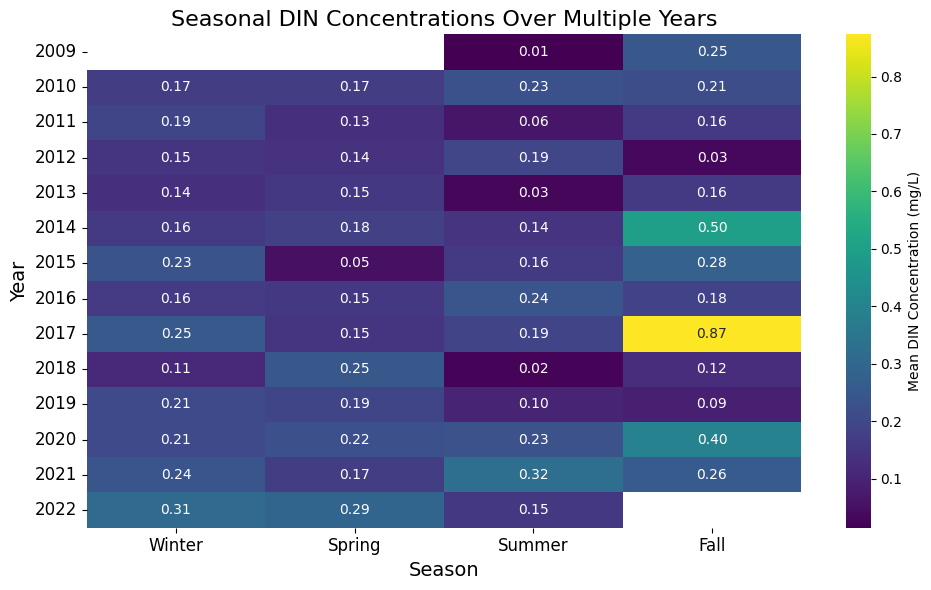

In [59]:
# Make sure 'date' is in YYYY-MM-DD format and 'DIN_concentration' holds the DIN data
# Extract year, month, and season from the date
df_mod['year'] = df_mod['date'].dt.year
df_mod['month'] = df_mod['date'].dt.month
df_mod['season'] = pd.cut(df_mod['month'], bins=[0, 3, 6, 9, 12], 
                      labels=['Winter', 'Spring', 'Summer', 'Fall'], right=False)

# Calculate total DIN load and total flow for each year and season
seasonal_totals = df_mod.groupby(['year', 'season']).agg(
    total_DIN_load=(din_load_col, 'sum'),
    total_flow=(flow_col, 'sum')
).reset_index()

# Calculate seasonal DIN concentration
seasonal_totals['DIN_concentration'] = 1e9/86400/1000*seasonal_totals['total_DIN_load'] / seasonal_totals['total_flow']

# Calculate mean DIN concentration for each year and season
seasonal_avg = seasonal_totals.groupby(['year', 'season'])['DIN_concentration'].mean().unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_avg, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Mean DIN Concentration (mg/L)'})

# Customize the plot
plt.title('Seasonal DIN Concentrations Over Multiple Years', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout for better fit
plt.show()

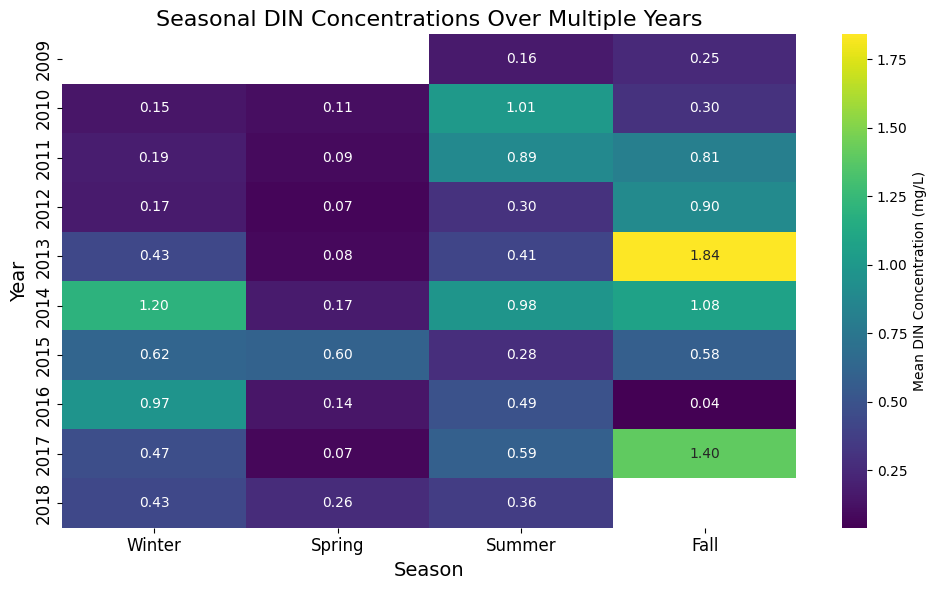

In [60]:
# Make sure 'date' is in YYYY-MM-DD format and 'DIN_concentration' holds the DIN data
# Extract year, month, and season from the date
df_obs['date'] = pd.to_datetime(df_obs['date'], format='%Y-%m-%d')
df_obs['year'] = df_obs['date'].dt.year
df_obs['month'] = df_obs['date'].dt.month
df_obs['season'] = pd.cut(df_obs['month'], bins=[0, 3, 6, 9, 12], 
                      labels=['Winter', 'Spring', 'Summer', 'Fall'], right=False)

# Calculate total DIN load and total flow for each year and season
seasonal_totals = df_obs.groupby(['year', 'season']).agg(
    total_DIN_load=(din_load_col, 'sum'),
    total_flow=(flow_col, 'sum')
).reset_index()

# Calculate seasonal DIN concentration
seasonal_totals['DIN_concentration'] = 1e9/86400/1000*seasonal_totals['total_DIN_load'] / seasonal_totals['total_flow']

# Calculate mean DIN concentration for each year and season
seasonal_avg = seasonal_totals.groupby(['year', 'season'])['DIN_concentration'].mean().unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(seasonal_avg, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Mean DIN Concentration (mg/L)'})

# Customize the plot
plt.title('Seasonal DIN Concentrations Over Multiple Years', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Year', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout for better fit
plt.show()

In [55]:
df_obs['date']

0       2009-07-01
1       2009-07-02
2       2009-07-03
3       2009-07-04
4       2009-07-05
           ...    
3282    2018-06-26
3283    2018-06-27
3284    2018-06-28
3285    2018-06-29
3286    2018-06-30
Name: date, Length: 3287, dtype: object